In [1]:
import torch
import interpol
import matplotlib.pyplot as plt

Generate the picture of a circle
--------------------------------

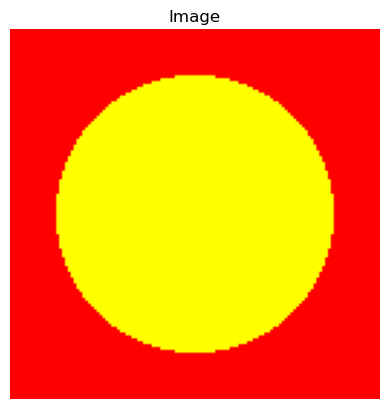

In [2]:
shape = [128, 128]
img = torch.stack(torch.meshgrid(*[torch.arange(s).float() for s in shape]), -1)
img -= (torch.as_tensor(shape).float() - 1) / 2
img = img.square().sum(-1).sqrt()
img = (img < 48).float()

plt.imshow(img, cmap='autumn')
plt.axis('off')
plt.title('Image')
plt.show()

Generate a random sampling grid
-------------------------------
We use Cubic splines with randomly sampled coefficients to generate a
smooth random displacement field.

We then add the _identity grid_ (_i.e._, the coordinate at each voxel)
to generate a sampling field (scipy's `points`)

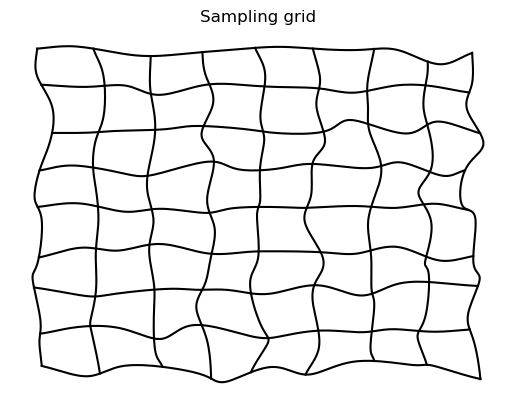

In [3]:
cshape = [12, 12]   # number of control points
scale = 2          # standard deviation of random displacement size
disp = torch.randn([*cshape, 2]) * scale

# interpol.resize expects the number of channels to be first, so we move
# it around
disp = disp.movedim(-1, 0)
disp = interpol.resize(disp, shape=shape, interpolation=3)
disp = disp.movedim(0, -1)

# convert the *displacement* field into a *sampling* field
identity = torch.stack(torch.meshgrid(*[torch.arange(s).float() for s in shape]), -1)
grid = identity + disp

# display the displacement field
skip = 16
for i in range(0, 128, skip):
    plt.plot(grid[i, :, 1], grid[i, :, 0], color='k')
plt.plot(grid[-1, :, 1], grid[-1, :, 0], color='k')
for j in range(0, 128, skip):
    plt.plot(grid[:, j, 1], grid[:, j, 0], color='k')
plt.plot(grid[:, -1, 1], grid[:, -1, 0], color='k')
plt.axis('off')
plt.title('Sampling grid')
plt.show()

Interpolate the image using the sampling grid
---------------------------------------------
By default, grid_pull and grid_grad do not apply a prefilter,
so `img` actually contains the spline coefficients.
To actually interpolate `img`, use `prefilter=True`.

Another thing to keep in mind is that the sampled image normals (returned
by `grid_grad`) are with respect to the original lattice. That is, if the
sampling grid contains a 90 degree rotation, the plotted normals will
be parallel to the edges of the warped image, instead of perpendicular.
To get normals with respect to the output lattice, the sampled normals
should be matrix-multiplied with the Jacobian field of the transform.
In other words, `grid_grad` returns (∇f)∘φ(x), not ∇(f∘φ)(x).

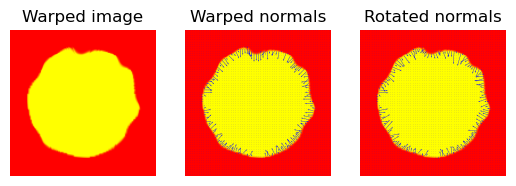

In [4]:
wrp = interpol.grid_pull(img, grid, interpolation=3)
nrm = interpol.grid_grad(img, grid, interpolation=3)

# compute Jacobian
jac = torch.zeros([*grid.shape, 2])
jac[1:-1, :, :, 0] = (disp[2:, :] - disp[:-2, :]) / 2
jac[:, 1:-1, :, 1] = (disp[:, 2:] - disp[:, :-2]) / 2
jac.diagonal(0, -1, -2).add_(1)

# compute rotated normals = ∇(f∘φ)
rot_nrm = jac.transpose(-1, -2).matmul(nrm.unsqueeze(-1)).squeeze(-1)

cmap = 'autumn'
skip = 2

plt.subplot(1, 3, 1)
plt.imshow(wrp, cmap=cmap)
plt.axis('off')
plt.title('Warped image')
plt.subplot(1, 3, 2)
plt.imshow(wrp, cmap=cmap)
plt.quiver(identity[::skip, ::skip, 1], identity[::skip, ::skip, 0],
           nrm[::skip, ::skip, 1], nrm[::skip, ::skip, 0],
           angles='xy', scale=0.1, scale_units='xy', color='blue')
plt.axis('off')
plt.title('Warped normals')
plt.subplot(1, 3, 3)
plt.imshow(wrp, cmap=cmap)
plt.quiver(identity[::skip, ::skip, 1], identity[::skip, ::skip, 0],
           rot_nrm[::skip, ::skip, 1], rot_nrm[::skip, ::skip, 0],
           angles='xy', scale=0.1, scale_units='xy', color='blue')
plt.axis('off')
plt.title('Rotated normals')
plt.show()